get the dataset

使用normal生成高斯分布，reshape使得shape相同。[:,1]去第二个特征。detach取消反向传播

torch.Size([1000, 1]) torch.Size([1000, 2]) <class 'torch.Tensor'>


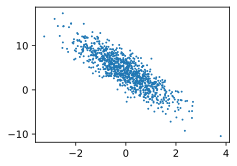

In [52]:
import torch
from d2l import torch as d2l
def synthesis(example_num,w,b):
  x=torch.normal(0,1,(example_num,len(w)))
  y=torch.matmul(x,w)+b
  y+=torch.normal(0,0.01,y.shape)
  return x,y.reshape((-1,1))

w=torch.tensor([2,-3.4])
b=4.2
x,y=synthesis(1000,w,4.2)
print(y.shape,x.shape,type(x))

d2l.set_figsize()
#detach to avoid back propagation
d2l.plt.scatter(x[:,(1)].detach().numpy(),y.detach().numpy(),1)

#d2l.plt.scatter(x[:,1],y,1)

读取数据集

使用yield返回iter, random.shuffle洗牌下标，tensor的去下标操作。

In [26]:
import random
def data_iter(batch_size,features,labels):
  n=len(features)
  indices=list(range(n))
  random.shuffle(indices)
  for i in range(0,n,batch_size):
    batch_indices=indices[i:min(i+batch_size,n)]
    yield features[batch_indices],labels[batch_indices]

for a,b in data_iter(10,x,y):
  print(a,b)
  break

tensor([[-0.1464, -0.2488],
        [-0.2521, -0.3623],
        [ 1.1624, -0.5019],
        [-0.7132, -0.9241],
        [ 0.0823, -0.3794],
        [-0.5938, -1.0328],
        [ 1.8306, -0.9676],
        [-1.1008, -0.3166],
        [ 1.0753,  1.8793],
        [-0.7241, -1.5613]]) tensor([[ 4.7431],
        [ 4.9171],
        [ 8.2295],
        [ 5.8982],
        [ 5.6423],
        [ 6.5251],
        [11.1594],
        [ 3.0674],
        [-0.0579],
        [ 8.0665]])


建立模型

torch初始化参数，定义模型，损失函数，优化算法。

with torch.no_grad() 强制不进行计算图

In [55]:


def linreg(x,w,b):
  return torch.matmul(x,w)+b

def squared_loss(y,y_hat):
  return (y.reshape(y_hat.shape)-y_hat)**2/2
# because use the sum to backpropagate
def sgd(params,lr,batch_size):
  with torch.no_grad():
    for param in params:
      param-=lr*param.grad/batch_size
      param.grad.zero_()

训练

loss没有下降的原因是训练好了没有重新随机参数，loss已经达到极限了。

对l的sum backword后，grad已经算好了，再用sgd更新每个param即可。

In [56]:
W=torch.normal(0,1,size=(2,1),requires_grad=True)
B=torch.zeros(1,requires_grad=True)
print(W,B)
lr=0.03
epoch_num=3
batch_size=10
net=linreg
loss=squared_loss
for epoch in range(epoch_num):
    for X,Y in data_iter(batch_size,x,y):
    
        l=loss(Y,net(X,W,B))
        l.sum().backward()
        sgd([W,B],lr,batch_size)
    with torch.no_grad():
        l=loss(y,net(x,W,B)).mean()
        print(f'epoch:{epoch+1},loss:{l},W:{W},b:{b}')

tensor([[0.9275],
        [0.9606]], requires_grad=True) tensor([0.], requires_grad=True)
epoch:1,loss:0.04185286909341812,W:tensor([[ 1.9497],
        [-3.1814]], requires_grad=True),b:4.2
epoch:2,loss:0.0001432640419807285,W:tensor([[ 1.9976],
        [-3.3895]], requires_grad=True),b:4.2
epoch:3,loss:5.340496500139125e-05,W:tensor([[ 1.9995],
        [-3.4003]], requires_grad=True),b:4.2


In [50]:
print(W.shape,w.shape)
#print(B.shape,b.shape)
print(W.reshape(w.shape)-w)
print(B-4.2)

torch.Size([2, 1]) torch.Size([2])
tensor([-0.0002, -0.0006], grad_fn=<SubBackward0>)
tensor([-0.0005], grad_fn=<SubBackward0>)


In [57]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

调用torch来建立模型



In [59]:
from torch.utils import data
#need add *to create dataset from list
dataset=data.TensorDataset(*(features,labels))
#dataloader is iterator
data_iter=data.DataLoader(dataset,batch_size,shuffle=True)
from torch import nn
#Sequential类将多个层串联在一起
# 第一个指定输入特征形状，即2，第二个指定输出特征形状，输出特征形状为单个标量，因此为1。
net=nn.Sequential(nn.Linear(2,1))
# 我们通过net[0]选择网络中的第一个图层， 然后使用weight.data和bias.data方法访问参数。 
# 我们还可以使用替换方法normal_和fill_来重写参数值。
net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0)

#return mean
loss=nn.MSELoss()

trainer=torch.optim.SGD(net.parameters(),lr=0.03)


如果我们用nn.MSELoss(reduction=‘sum’)替换 ，nn.MSELoss（）”为了使代码的行为相同，需要怎么更改学习速率？为什么？
答：应该把学习率除以batch_size，因为默认参数是’mean’，换成’sum’需要除以批量数，一般会采用默认，因为这样学习率可以跟batch_size解耦

In [63]:
#训练
num_epoch=3
for epoch in range(num_epoch):
  for X,y in data_iter:
    l=loss(net(X),y)
    trainer.zero_grad()
    l.backward()
    trainer.step()
  l=loss(net(features),labels)
  print(f'epoch:{epoch+1},loss:{l}')



epoch:1,loss:0.00010096814366988838
epoch:2,loss:0.00010081629443448037
epoch:3,loss:0.00010127385030500591


In [64]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([ 8.3447e-07, -4.3178e-04])
b的估计误差： tensor([-0.0006])
